In [1]:
import numpy as np
import copy
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
import torch
import torch.nn as nn
import dtnnlib as dtnn

In [3]:
from sklearn.datasets import make_classification, make_blobs

In [4]:
def twospirals(n_points, noise=.5, angle=784):
    """
     Returns the two spirals dataset.
    """
    n = np.sqrt(np.random.rand(n_points,1)) * angle * (2*np.pi)/360
    d1x = -np.cos(n)*n + np.random.rand(n_points,1) * noise
    d1y = np.sin(n)*n + np.random.rand(n_points,1) * noise
    return (np.vstack((np.hstack((d1x,d1y)),np.hstack((-d1x,-d1y)))), 
            np.hstack((np.zeros(n_points),np.ones(n_points))))

In [5]:
device = torch.device("cuda:0")
# device = torch.device("cpu")

## Viz Residual

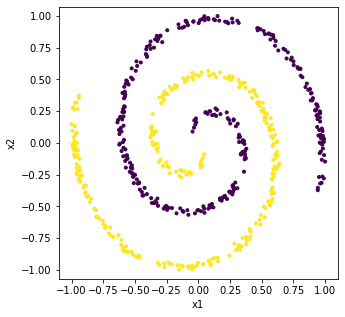

In [6]:
x, y = twospirals(300, angle=560)
x, y = x/x.max(axis=0, keepdims=True), y.reshape(-1)
xx, yy = torch.FloatTensor(x), torch.FloatTensor(y.reshape(-1,1))

x1 = xx[:,0]
x2 = xx[:,1]

%matplotlib inline
plt.figure(figsize=(5,5))
plt.scatter(x1, x2, c=y, marker='.')
# plt.savefig("./clf_toy_data.pdf")
plt.xlabel("x1")
plt.ylabel("x2")
plt.axis("equal")
plt.show()

In [7]:
xx, yy = xx.to(device), yy.to(device)

In [8]:
class SoftmaxTemp(nn.Module):
    def __init__(self, temp=3.0):
        super().__init__()
        self.temp = temp
        
    def forward(self, x):
        return torch.softmax(x*self.temp, dim=-1)

In [9]:
class ResidualMLP(nn.Module):
    
    def __init__(self, h):
        super().__init__()
        self.net = nn.Sequential(
#             dtnn.DistanceTransformBase(2, h),
            dtnn.DistanceTransform(2, h),
            nn.Sequential(dtnn.ScaleShift(h, scale_init=10, shift_init=None), ### Shift is learnable, scale is fixed
                            nn.Softmax(dim=-1)),
#             dtnn.DistanceTransform_MinExp(2, h, bias=False),
#             SoftmaxTemp(10.0),
#             nn.BatchNorm1d(h),
#             nn.ELU(),
#             dtnn.OneActiv(h, mode="relu"),
            dtnn.OneActiv(h, mode="exp_1.6"),
            nn.Linear(h, 2),
            )
        self.net[0].centers.data = torch.randn_like(self.net[0].centers)/3.
        self.clf = nn.Linear(2, 1)
        
    def forward(self, x):
        return torch.sigmoid(self.clf(x + self.net(x)))
#         return torch.sigmoid(self.clf(self.net(x)))

In [10]:
net = ResidualMLP(10).to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
# optimizer = torch.optim.SGD(net.parameters(), lr=0.001)

criterion = nn.BCELoss()
# criterion = nn.MSELoss()

_________________________
Epoch: 99, Acc:0.42, Loss:0.711901843547821
Epoch: 199, Acc:0.53, Loss:0.6932801008224487
Epoch: 299, Acc:0.59, Loss:0.6786710023880005
Epoch: 399, Acc:0.65, Loss:0.6461614370346069
Epoch: 499, Acc:0.76, Loss:0.5679219365119934
Epoch: 599, Acc:0.92, Loss:0.45286011695861816
Epoch: 699, Acc:0.98, Loss:0.336642861366272
Epoch: 799, Acc:0.99, Loss:0.24424174427986145
Epoch: 899, Acc:0.99, Loss:0.17732912302017212
Epoch: 999, Acc:1.00, Loss:0.13074041903018951


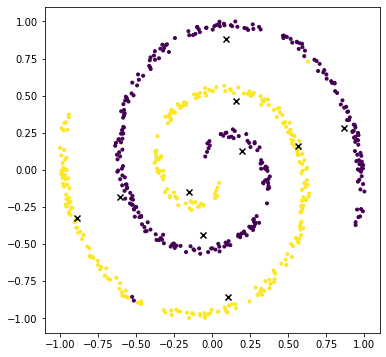

Epoch: 1099, Acc:1.00, Loss:0.09637842327356339
Epoch: 1199, Acc:1.00, Loss:0.07358159869909286
Epoch: 1299, Acc:1.00, Loss:0.05772850289940834
Epoch: 1399, Acc:1.00, Loss:0.046236418187618256
Epoch: 1499, Acc:1.00, Loss:0.03769022226333618
Epoch: 1599, Acc:1.00, Loss:0.03119119629263878
Epoch: 1699, Acc:1.00, Loss:0.026150589808821678
Epoch: 1799, Acc:1.00, Loss:0.02217254228889942
Epoch: 1899, Acc:1.00, Loss:0.01898455061018467
Epoch: 1999, Acc:1.00, Loss:0.016394754871726036


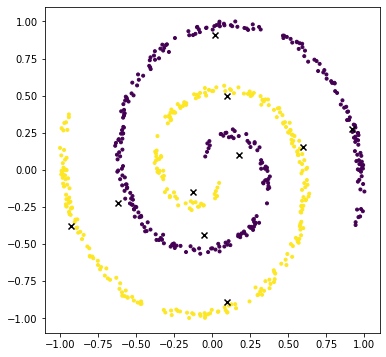

Epoch: 2099, Acc:1.00, Loss:0.014265372417867184
Epoch: 2199, Acc:1.00, Loss:0.012495637871325016
Epoch: 2299, Acc:1.00, Loss:0.011010583490133286
Epoch: 2399, Acc:1.00, Loss:0.009753618389368057
Epoch: 2499, Acc:1.00, Loss:0.008681384846568108
Epoch: 2599, Acc:1.00, Loss:0.007760266773402691
Epoch: 2699, Acc:1.00, Loss:0.0069638872519135475
Epoch: 2799, Acc:1.00, Loss:0.0062713236548006535
Epoch: 2899, Acc:1.00, Loss:0.005665814969688654
Epoch: 2999, Acc:1.00, Loss:0.005133831407874823


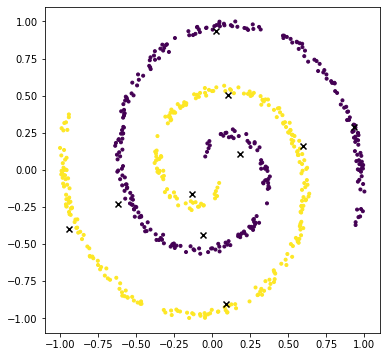

Epoch: 3099, Acc:1.00, Loss:0.004664334934204817
Epoch: 3199, Acc:1.00, Loss:0.004248271696269512
Epoch: 3299, Acc:1.00, Loss:0.003878151997923851
Epoch: 3399, Acc:1.00, Loss:0.003547731786966324
Epoch: 3499, Acc:1.00, Loss:0.0032517884392291307
Epoch: 3599, Acc:1.00, Loss:0.0029859088826924562
Epoch: 3699, Acc:1.00, Loss:0.0027463692240417004
Epoch: 3799, Acc:1.00, Loss:0.002529983874410391
Epoch: 3899, Acc:1.00, Loss:0.0023340373300015926
Epoch: 3999, Acc:1.00, Loss:0.0021561821922659874


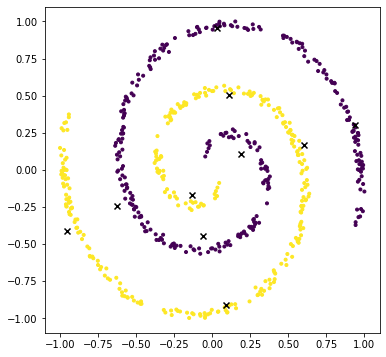

Epoch: 4099, Acc:1.00, Loss:0.0019944063387811184
Epoch: 4199, Acc:1.00, Loss:0.0018469566712155938
Epoch: 4299, Acc:1.00, Loss:0.0017123075667768717
Epoch: 4399, Acc:1.00, Loss:0.0015891247894614935
Epoch: 4499, Acc:1.00, Loss:0.0014762504724785686
Epoch: 4599, Acc:1.00, Loss:0.0013726575998589396
Epoch: 4699, Acc:1.00, Loss:0.0012774380156770349
Epoch: 4799, Acc:1.00, Loss:0.0011897925287485123
Epoch: 4899, Acc:1.00, Loss:0.0011090139159932733
Epoch: 4999, Acc:1.00, Loss:0.001034470391459763


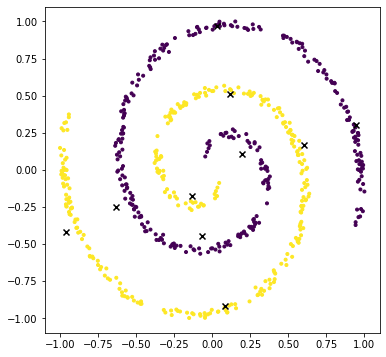

In [11]:
print("_________________________")
for epoch in range(5000):
    yout = net(xx)
    loss = criterion(yout, yy)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch+1)%100 == 0:
        accuracy = ((yout>0.5).type(torch.float32) == yy).type(torch.float).mean()                
        print(f'Epoch: {epoch}, Acc:{float(accuracy):.2f}, Loss:{float(loss)}')

    if (epoch+1)%1000 == 0:
        ax = plt.figure(figsize=(6,6)).add_subplot()
        out = (yout.data.cpu().numpy()>0.5).astype(int)
        ax.scatter(x1, x2, c=out, marker= '.')
        ## plot centroids
        c = net.net[0].centers.data.cpu()
        ax.scatter(c[:,0], c[:,1], color='k', marker= 'x')
        plt.show()

In [12]:
xx.device

device(type='cuda', index=0)

(array([  2.,   1.,   4.,   7.,   2.,  11.,  12.,  24.,  52., 485.]),
 array([0.3683417 , 0.43150753, 0.49467337, 0.5578392 , 0.62100506,
        0.68417084, 0.7473367 , 0.8105025 , 0.8736683 , 0.93683416,
        1.        ], dtype=float32),
 <BarContainer object of 10 artists>)

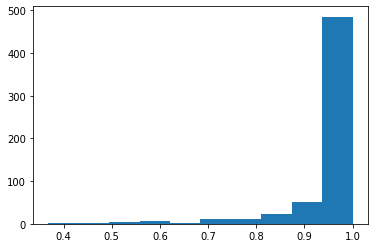

In [13]:
maxvals = net.net[:-1](xx).data.cpu().max(dim=1)[0]
plt.hist(maxvals)

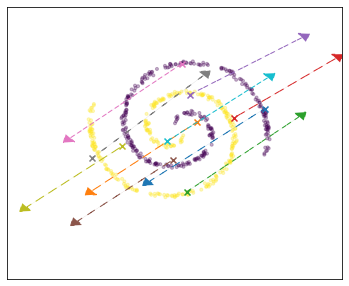

In [14]:
yout = net(xx)
ax = plt.figure(figsize=(6,5)).add_subplot()
out = (yout.data.cpu().numpy()>0.5).astype(int)
ax.scatter(x1, x2, c=out, marker= '.', alpha=0.3)
## plot centroids
c = net.net[0].centers.data.cpu()
d = net.net[-1].weight.data.cpu().t()*0.5 #+ net.net[-1].bias.data.cpu()


for i in range(c.shape[0]):
    color = matplotlib.cm.tab10(i)
    ax.arrow(c[i,0], c[i,1], d[i,0], d[i,1], head_width=0.15, head_length=0.1, fc=color, ec=color, linestyle=(0, (5, 10)))
    ax.scatter(c[i,0], c[i,1], color=color, marker= 'x')
    
plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
plt.xlim(-1.9, 1.8)
plt.ylim(-2.2, 1.8)

# plt.savefig("./outputs/01.0_viz_clf_vector_0.pdf", bbox_inches='tight')
plt.show()

In [15]:
net.net[-1].weight.data.cpu().t() + net.net[-1].bias.data.cpu()

tensor([[-2.7906, -1.9388],
        [-2.5640, -1.8289],
        [ 2.2374,  2.4055],
        [ 2.0068,  1.9506],
        [ 2.2362,  1.8776],
        [-2.3591, -1.6094],
        [-2.7205, -1.9949],
        [ 2.2186,  2.6276],
        [-2.3538, -1.5912],
        [ 1.9839,  2.0712]])

In [16]:
net.net[1][0].shifter

Parameter containing:
tensor([[ 2.2897, -0.9706,  2.4572, -0.5950, -1.3469, -0.7184,  3.6194,  3.2538,
         -1.0081, -1.0301]], device='cuda:0', requires_grad=True)

## Constrain gradient to move towards nearest Data points

In [72]:
def similarity(point, other_points):
    '''
    point -> [m, dim]: point from which direction is found 
    other_points -> [N, dim]: other valid points to find the direction
    '''
    
    vecs = other_points.unsqueeze(0)-point.unsqueeze(1)
    vecs_mag = torch.norm(vecs, p=2, dim=-1, keepdim=True)
    return vecs_mag.squeeze(-1)

In [73]:
num_points = 100
X1 = np.linspace(-1.0, 1.0, num_points)
X2 = np.linspace(0.0, 2.0, num_points)

# X1 = np.linspace(-0.6, -0.4, num_points)
# X2 = np.linspace(0.9, 1.1, num_points)

X1, X2 = np.meshgrid(X1, X2)

XX_grid = torch.Tensor(np.c_[X1.reshape(-1), X2.reshape(-1)])

In [74]:
point = torch.Tensor([[-0.5, 1]])

In [75]:
sim = similarity(point, XX_grid)

In [76]:
## reduce output variance
# sim = (sim.abs() ** (1/10)) *sim.sign()

tensor([-0.4949,  1.0101])


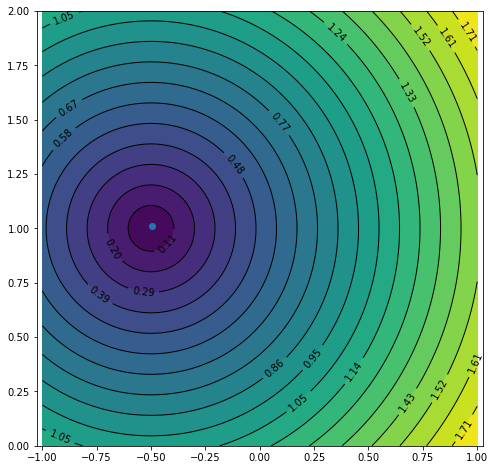

In [77]:
%matplotlib inline
LVLs = np.linspace(sim.min(), sim.max(), 20)

plt.figure(figsize=(8,8))
plt.contourf(X1, X2, sim.data.numpy().reshape(X1.shape), levels=LVLs)
cs = plt.contour(X1, X2, sim.data.numpy().reshape(X1.shape), levels=LVLs, linestyles="None", colors="k", linewidths=1)
plt.clabel(cs, cs.levels, inline=True, fontsize=10, fmt="%1.2f")

xx_max = XX_grid[sim.argmin()]
plt.scatter(*xx_max)
plt.axis('equal')
print(xx_max)

In [235]:
class ResidualMLP(nn.Module):
    
    def __init__(self, h):
        super().__init__()
        self.net = nn.Sequential(
            dtnn.DistanceTransform(2, h),
            nn.Sequential(dtnn.ScaleShift(h, scale_init=20, shift_init=None), ### Shift is learnable, scale is fixed
                            nn.Softmax(dim=-1)),
            dtnn.OneActiv(h, mode="exp_1.6"),
            nn.Linear(h, 2),
            )
        self.net[0].centers.data = torch.randn_like(self.net[0].centers)/3.
        self.clf = nn.Linear(2, 1)
        
    def forward(self, x):
        return torch.sigmoid(self.clf(x + self.net(x)))

In [245]:
net = ResidualMLP(10).to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

criterion = nn.BCELoss()

Epoch: 99, Acc:0.95, Loss:0.08177699148654938
Epoch: 199, Acc:0.95, Loss:0.08108698576688766
Epoch: 299, Acc:0.95, Loss:0.08034137636423111
Epoch: 399, Acc:0.95, Loss:0.07966751605272293
Epoch: 499, Acc:0.95, Loss:0.07894890010356903
Epoch: 599, Acc:0.95, Loss:0.07828358560800552
Epoch: 699, Acc:0.95, Loss:0.07764764130115509
Epoch: 799, Acc:0.96, Loss:0.076952263712883
Epoch: 899, Acc:0.96, Loss:0.07629964500665665
Epoch: 999, Acc:0.96, Loss:0.07563965022563934


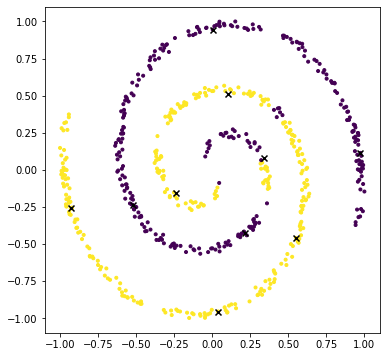

Epoch: 1099, Acc:0.96, Loss:0.07498976588249207
Epoch: 1199, Acc:0.96, Loss:0.07433086633682251
Epoch: 1299, Acc:0.96, Loss:0.07370296865701675
Epoch: 1399, Acc:0.96, Loss:0.07304811477661133
Epoch: 1499, Acc:0.96, Loss:0.07237090170383453
Epoch: 1599, Acc:0.96, Loss:0.07173090428113937
Epoch: 1699, Acc:0.96, Loss:0.07109648734331131
Epoch: 1799, Acc:0.97, Loss:0.07045210897922516
Epoch: 1899, Acc:0.97, Loss:0.06983458250761032
Epoch: 1999, Acc:0.97, Loss:0.06915660947561264


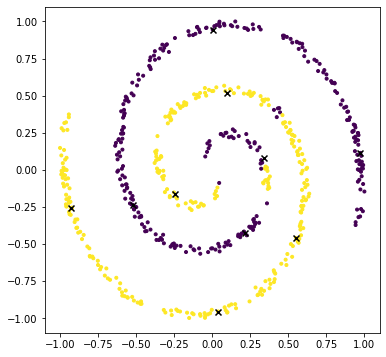

Epoch: 2099, Acc:0.97, Loss:0.06850361078977585
Epoch: 2199, Acc:0.97, Loss:0.06784768402576447
Epoch: 2299, Acc:0.97, Loss:0.0672159194946289
Epoch: 2399, Acc:0.97, Loss:0.06656790524721146
Epoch: 2499, Acc:0.97, Loss:0.06591837853193283
Epoch: 2599, Acc:0.97, Loss:0.06527029722929001
Epoch: 2699, Acc:0.97, Loss:0.06465643644332886
Epoch: 2799, Acc:0.97, Loss:0.06399908661842346
Epoch: 2899, Acc:0.97, Loss:0.06335880607366562
Epoch: 2999, Acc:0.98, Loss:0.06271843612194061


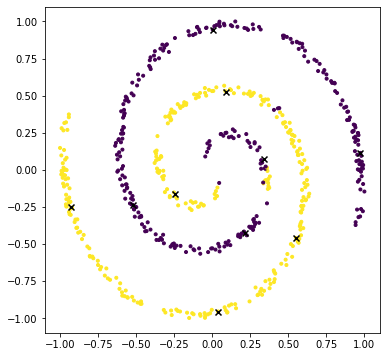

Epoch: 3099, Acc:0.98, Loss:0.06208684295415878
Epoch: 3199, Acc:0.98, Loss:0.06145964935421944
Epoch: 3299, Acc:0.98, Loss:0.06085749343037605
Epoch: 3399, Acc:0.98, Loss:0.0602424256503582
Epoch: 3499, Acc:0.99, Loss:0.05963507294654846
Epoch: 3599, Acc:0.99, Loss:0.05901029706001282
Epoch: 3699, Acc:0.99, Loss:0.058370064944028854
Epoch: 3799, Acc:0.99, Loss:0.057768773287534714
Epoch: 3899, Acc:0.99, Loss:0.05723051726818085
Epoch: 3999, Acc:0.99, Loss:0.05673103407025337


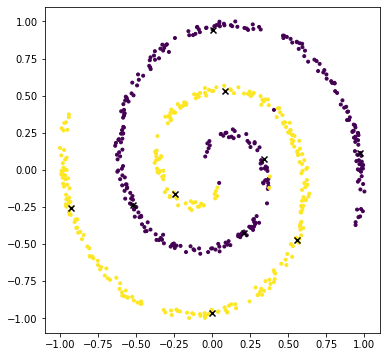

Epoch: 4099, Acc:0.99, Loss:0.056223802268505096
Epoch: 4199, Acc:1.00, Loss:0.05564101040363312
Epoch: 4299, Acc:1.00, Loss:0.05512676388025284
Epoch: 4399, Acc:1.00, Loss:0.05461280792951584
Epoch: 4499, Acc:1.00, Loss:0.05397477746009827
Epoch: 4599, Acc:1.00, Loss:0.05341882258653641
Epoch: 4699, Acc:1.00, Loss:0.05279040336608887
Epoch: 4799, Acc:1.00, Loss:0.05224582925438881
Epoch: 4899, Acc:1.00, Loss:0.05165184661746025
Epoch: 4999, Acc:1.00, Loss:0.051095474511384964


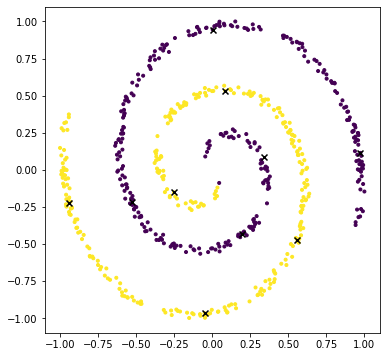

In [254]:
for epoch in range(5000):
    yout = net(xx)
    loss = criterion(yout, yy)
    optimizer.zero_grad()
    loss.backward()
    
    ########################################
    ## Penalty for being far from known centers
    min_dist = similarity(net.net[0].centers, xx).min(dim=0)[0]
#     print(min_dist.shape)
#     break
    loss2 = min_dist.pow(0.5).mean()
    loss2.backward()
    ########################################
    
    optimizer.step()
    if (epoch)%1000 == 0 and epoch > 2000:
        net.net[0].centers.data = xx[similarity(net.net[0].centers, xx).argmin(dim=1)]
#         optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

    if (epoch+1)%100 == 0:
        accuracy = ((yout>0.5).type(torch.float32) == yy).type(torch.float).mean()                
        print(f'Epoch: {epoch}, Acc:{float(accuracy):.2f}, Loss:{float(loss)}')

    if (epoch+1)%1000 == 0:
        ax = plt.figure(figsize=(6,6)).add_subplot()
        out = (yout.data.cpu().numpy()>0.5).astype(int)
        ax.scatter(x1, x2, c=out, marker= '.')
        ## plot centroids
        c = net.net[0].centers.data.cpu()
        ax.scatter(c[:,0], c[:,1], color='k', marker= 'x')
        plt.show()

In [255]:
similarity(net.net[0].centers, xx).min(dim=1)[1]

tensor([241, 330, 224, 400, 213, 424, 304, 580, 208, 286], device='cuda:0')

In [256]:
similarity(net.net[0].centers, xx).min(dim=0)[1]

tensor([0, 4, 2, 8, 0, 0, 4, 4, 1, 0, 0, 8, 4, 4, 4, 4, 0, 4, 4, 3, 8, 0, 4, 2,
        3, 8, 9, 4, 1, 8, 2, 8, 3, 9, 0, 8, 4, 0, 8, 0, 8, 2, 8, 8, 4, 4, 9, 3,
        0, 5, 8, 2, 0, 3, 8, 4, 8, 4, 5, 4, 0, 4, 4, 2, 4, 3, 0, 8, 9, 0, 0, 4,
        1, 2, 2, 0, 4, 4, 4, 9, 8, 2, 0, 9, 9, 0, 1, 0, 0, 8, 3, 8, 1, 1, 8, 8,
        4, 8, 0, 4, 9, 4, 2, 0, 0, 2, 9, 9, 8, 9, 4, 2, 3, 3, 0, 9, 2, 0, 9, 0,
        8, 2, 4, 4, 3, 9, 4, 2, 4, 4, 8, 3, 4, 4, 0, 0, 8, 8, 0, 8, 2, 0, 8, 4,
        4, 0, 0, 0, 9, 2, 1, 2, 9, 8, 2, 9, 0, 3, 2, 4, 3, 9, 8, 4, 2, 8, 9, 8,
        4, 4, 4, 8, 4, 2, 9, 4, 0, 2, 8, 2, 8, 0, 4, 4, 0, 8, 9, 3, 8, 2, 1, 9,
        9, 0, 4, 4, 3, 8, 5, 8, 4, 9, 0, 3, 8, 3, 2, 4, 8, 3, 4, 4, 2, 4, 9, 0,
        8, 8, 0, 8, 2, 9, 4, 3, 2, 4, 9, 4, 9, 4, 8, 9, 0, 2, 8, 9, 2, 1, 8, 0,
        4, 0, 2, 8, 0, 0, 4, 8, 9, 9, 0, 4, 3, 0, 8, 8, 8, 9, 8, 9, 8, 0, 8, 0,
        3, 4, 3, 3, 4, 2, 0, 4, 0, 9, 8, 1, 3, 3, 8, 9, 8, 9, 0, 3, 4, 9, 9, 1,
        0, 3, 3, 0, 8, 8, 8, 4, 2, 4, 0,

In [257]:
loss, loss2

(tensor(0.0511, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>),
 tensor(0.4667, device='cuda:0', grad_fn=<MeanBackward0>))

(array([ 10.,   4.,  10.,   9.,   9.,  14.,  10.,   8.,  17., 509.]),
 array([0.5181691 , 0.5663522 , 0.6145353 , 0.66271836, 0.71090144,
        0.7590846 , 0.80726767, 0.85545075, 0.90363383, 0.9518169 ,
        1.        ], dtype=float32),
 <BarContainer object of 10 artists>)

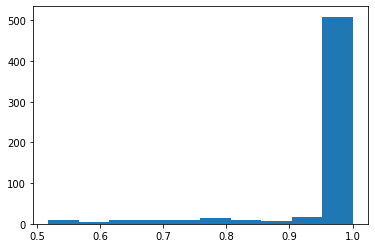

In [258]:
maxvals = net.net[:-1](xx).data.cpu().max(dim=1)[0]
plt.hist(maxvals)

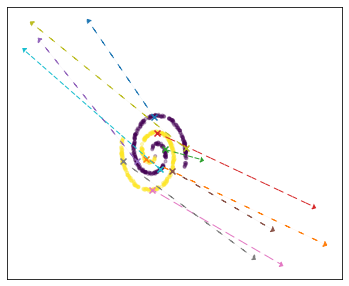

In [259]:
yout = net(xx)
ax = plt.figure(figsize=(6,5)).add_subplot()
out = (yout.data.cpu().numpy()>0.5).astype(int)
ax.scatter(x1, x2, c=out, marker= '.', alpha=0.3)
## plot centroids
c = net.net[0].centers.data.cpu()
d = net.net[-1].weight.data.cpu().t()*1.0 + net.net[-1].bias.data.cpu()


for i in range(c.shape[0]):
    color = matplotlib.cm.tab10(i)
    ax.arrow(c[i,0], c[i,1], d[i,0], d[i,1], head_width=0.15, head_length=0.1, fc=color, ec=color, linestyle=(0, (5, 10)))
    ax.scatter(c[i,0], c[i,1], color=color, marker= 'x')
    
plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
# plt.xlim(-1.9, 1.8)
# plt.ylim(-2.2, 1.8)

# plt.savefig("./outputs/01.0_viz_clf_vector_0.pdf", bbox_inches='tight')
plt.show()

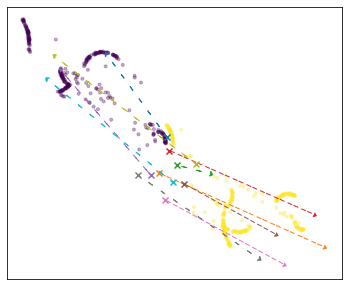

In [260]:
dev = (xx+net.net(xx)*1.0).data.cpu()

ax = plt.figure(figsize=(6,5)).add_subplot()

ax.scatter(dev[:,0], dev[:,1], c=out, marker= '.', alpha=0.3)
## plot centroids
c = net.net[0].centers.data.cpu()
d = net.net[-1].weight.data.cpu().t()*1.0 + net.net[-1].bias.data.cpu()
for i in range(c.shape[0]):
    color = matplotlib.cm.tab10(i)
    ax.arrow(c[i,0], c[i,1], d[i,0], d[i,1], head_width=0.15, head_length=0.1, fc=color, ec=color, linestyle=(0, (5, 10)))
    ax.scatter(c[i,0], c[i,1], color=color, marker= 'x')

plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
# plt.xlim(-1.9, 1.8)
# plt.ylim(-2.2, 1.8)

# plt.savefig("./outputs/01.0_viz_clf_vector_1.pdf", bbox_inches='tight')
plt.show()

In [253]:
similarity(net.net[0].centers, xx).min(dim=1)[0]

tensor([0.0005, 0.0151, 0.0186, 0.0365, 0.0005, 0.0013, 0.0009, 0.0050, 0.0041,
        0.0004], device='cuda:0', grad_fn=<MinBackward0>)

In [208]:
# net.net[0].centers.data = xx[similarity(net.net[0].centers, xx).argmin(dim=1)]

### Directional Similarity (Not properly Implemented)

In [441]:
def directional_similarity(point, direction, other_points):
    '''
    Calculates directional similarity
    point -> [m, dim]: point from which direction is found 
    direction -> [m, dim]: un-normalized direction in which to find similarity; OR negative gradient
    other_points -> [N, dim]: other valid points to find the direction
    '''
    
#     print(point.shape)
#     print(direction.shape)
#     print(other_points.shape)
    
#     C = torch.Tensor([[0]]).to(point.device)
    C = torch.norm(direction, p=1, dim=-1, keepdim=True)
#     print(C.shape)
    C = C.unsqueeze(1)
    
    ### direction towards +ve x-axis
#     direction = direction/torch.norm(direction, p=1, dim=-1, keepdim=True) ## always normalized
    vecs = other_points.unsqueeze(0)-point.unsqueeze(1)
    vecs_mag = torch.norm(vecs, p=1.5, dim=-1, keepdim=True)
#     print(vecs.shape, vecs_mag.shape, C.shape)
    vecs_dirn = vecs/(vecs_mag+1e-11+C) ## 1e-B for stability
    
#     print(vecs_dirn.shape, direction.unsqueeze(2).shape)
#     yout = vecs_dirn@direction.t() ## gives importance to direction
    yout = torch.bmm(vecs_dirn, direction.unsqueeze(2))## gives importance to direction
#     print(yout.shape, vecs_mag.shape)
    yout = yout/(vecs_mag+1e-11+C) ## gives inportance to similarity
    return yout.squeeze(-1)

In [442]:
num_points = 100
X1 = np.linspace(-1.0, 1.0, num_points)
X2 = np.linspace(0.0, 2.0, num_points)

# X1 = np.linspace(-0.6, -0.4, num_points)
# X2 = np.linspace(0.9, 1.1, num_points)

X1, X2 = np.meshgrid(X1, X2)

XX_grid = torch.Tensor(np.c_[X1.reshape(-1), X2.reshape(-1)])

In [443]:
point = torch.Tensor([[-1.0, 1]])
direction = torch.Tensor([[1, 0]])*0.15

In [444]:
sim = directional_similarity(point, direction, XX_grid)

In [445]:
## reduce output variance
# sim = (sim.abs() ** (1/10)) *sim.sign()

tensor([-0.8384,  1.0101])


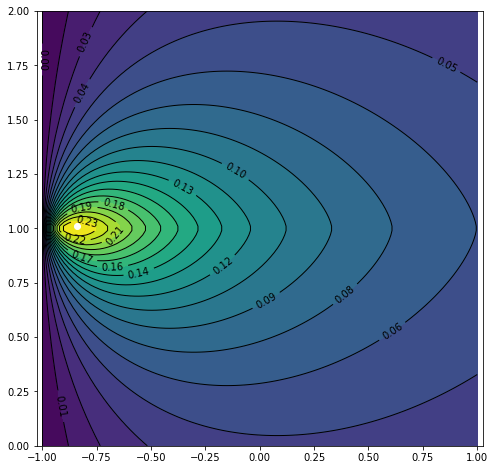

In [446]:
%matplotlib inline
LVLs = np.linspace(sim.min(), sim.max(), 20)

plt.figure(figsize=(8,8))
plt.contourf(X1, X2, sim.data.numpy().reshape(X1.shape), levels=LVLs)
cs = plt.contour(X1, X2, sim.data.numpy().reshape(X1.shape), levels=LVLs, linestyles="None", colors="k", linewidths=1)
plt.clabel(cs, cs.levels, inline=True, fontsize=10, fmt="%1.2f")

xx_max = XX_grid[sim.argmax()]
plt.scatter(*xx_max, c='white', zorder=10)
plt.axis('equal')
print(xx_max)

In [447]:
class ResidualMLP(nn.Module):
    
    def __init__(self, h):
        super().__init__()
        self.net = nn.Sequential(
            dtnn.DistanceTransform(2, h),
            nn.Sequential(dtnn.ScaleShift(h, scale_init=20, shift_init=None), ### Shift is learnable, scale is fixed
                            nn.Softmax(dim=-1)),
            dtnn.OneActiv(h, mode="exp_1.6"),
            nn.Linear(h, 2),
            )
        self.net[0].centers.data = torch.randn_like(self.net[0].centers)/3.
        self.clf = nn.Linear(2, 1)
        
    def forward(self, x):
        return torch.sigmoid(self.clf(x + self.net(x)))

In [448]:
net = ResidualMLP(10).to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

criterion = nn.BCELoss()

Epoch: 99, Acc:0.56, Loss:0.6596710085868835
Epoch: 199, Acc:0.59, Loss:0.6481932401657104
Epoch: 299, Acc:0.60, Loss:0.6379733085632324
Epoch: 399, Acc:0.59, Loss:0.6240378618240356
Epoch: 499, Acc:0.62, Loss:0.5986562371253967
Epoch: 599, Acc:0.73, Loss:0.564289927482605
Epoch: 699, Acc:0.79, Loss:0.4969263970851898
Epoch: 799, Acc:0.81, Loss:0.4272834360599518
Epoch: 899, Acc:0.83, Loss:0.37406042218208313
Epoch: 999, Acc:0.81, Loss:0.3349715769290924


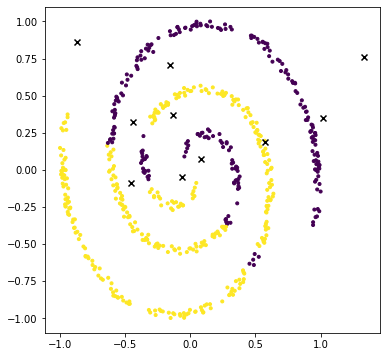

Epoch: 1099, Acc:0.82, Loss:0.3068661689758301
Epoch: 1199, Acc:0.82, Loss:0.29127320647239685
Epoch: 1299, Acc:0.86, Loss:0.25513896346092224
Epoch: 1399, Acc:0.86, Loss:0.2322314977645874
Epoch: 1499, Acc:0.88, Loss:0.20951294898986816
Epoch: 1599, Acc:0.88, Loss:0.20072056353092194
Epoch: 1699, Acc:0.90, Loss:0.1911880224943161
Epoch: 1799, Acc:0.90, Loss:0.18587380647659302
Epoch: 1899, Acc:0.89, Loss:0.1795361042022705
Epoch: 1999, Acc:0.89, Loss:0.1764882653951645


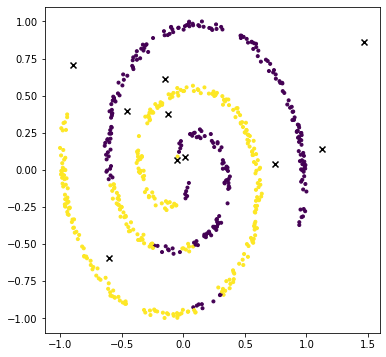

Epoch: 2099, Acc:0.90, Loss:0.1664658635854721
Epoch: 2199, Acc:0.91, Loss:0.1571764349937439
Epoch: 2299, Acc:0.91, Loss:0.14876103401184082
Epoch: 2399, Acc:0.92, Loss:0.14227703213691711
Epoch: 2499, Acc:0.94, Loss:0.1392451822757721
Epoch: 2599, Acc:0.94, Loss:0.13679568469524384
Epoch: 2699, Acc:0.96, Loss:0.1337447315454483
Epoch: 2799, Acc:0.97, Loss:0.13042129576206207
Epoch: 2899, Acc:0.98, Loss:0.1274336576461792
Epoch: 2999, Acc:0.98, Loss:0.12517276406288147


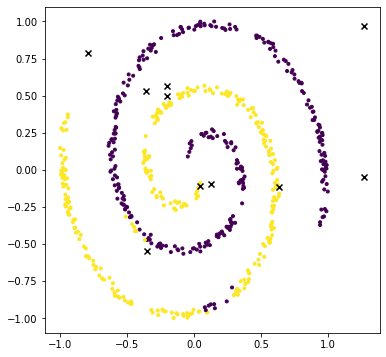

Epoch: 3099, Acc:0.98, Loss:0.1231677383184433
Epoch: 3199, Acc:0.99, Loss:0.12093298882246017
Epoch: 3299, Acc:0.98, Loss:0.11858055740594864
Epoch: 3399, Acc:0.99, Loss:0.11621735244989395
Epoch: 3499, Acc:0.99, Loss:0.11496061086654663
Epoch: 3599, Acc:0.99, Loss:0.11239545792341232
Epoch: 3699, Acc:0.99, Loss:0.10965177416801453
Epoch: 3799, Acc:0.99, Loss:0.10551734268665314
Epoch: 3899, Acc:0.99, Loss:0.10321208089590073
Epoch: 3999, Acc:0.99, Loss:0.09387856721878052


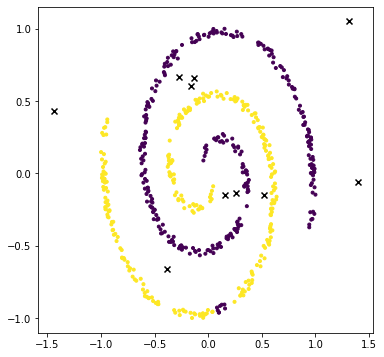

Epoch: 4099, Acc:0.99, Loss:0.09335848689079285
Epoch: 4199, Acc:0.99, Loss:0.08944839984178543
Epoch: 4299, Acc:0.99, Loss:0.08707340806722641
Epoch: 4399, Acc:0.99, Loss:0.0816630944609642
Epoch: 4499, Acc:0.99, Loss:0.07870404422283173
Epoch: 4599, Acc:0.99, Loss:0.07572906464338303
Epoch: 4699, Acc:0.99, Loss:0.0767614096403122
Epoch: 4799, Acc:0.99, Loss:0.07481227070093155
Epoch: 4899, Acc:0.99, Loss:0.07295229285955429
Epoch: 4999, Acc:1.00, Loss:0.07122446596622467


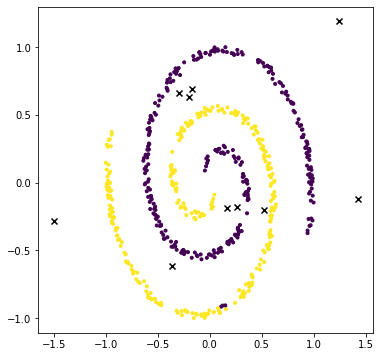

In [449]:
for epoch in range(5000):
    yout = net(xx)
    loss = criterion(yout, yy)    
    optimizer.zero_grad()
    loss.backward()
    
    ########################################
    ## Penalty for being far from known centers
    max_sim = directional_similarity(net.net[0].centers, -net.net[0].centers.grad, xx).max(dim=1)[0]
#     break
    loss2 = (max_sim.abs().pow(0.5)*max_sim.sign()).mean()
    loss2.backward()
    ########################################

    
    optimizer.step()

    if (epoch+1)%100 == 0:
        accuracy = ((yout>0.5).type(torch.float32) == yy).type(torch.float).mean()                
        print(f'Epoch: {epoch}, Acc:{float(accuracy):.2f}, Loss:{float(loss)}')

    if (epoch+1)%1000 == 0:
        ax = plt.figure(figsize=(6,6)).add_subplot()
        out = (yout.data.cpu().numpy()>0.5).astype(int)
        ax.scatter(x1, x2, c=out, marker= '.')
        ## plot centroids
        c = net.net[0].centers.data.cpu()
        ax.scatter(c[:,0], c[:,1], color='k', marker= 'x')
        plt.show()

In [450]:
loss2, loss

(tensor(0.3110, device='cuda:0', grad_fn=<MeanBackward0>),
 tensor(0.0712, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>))

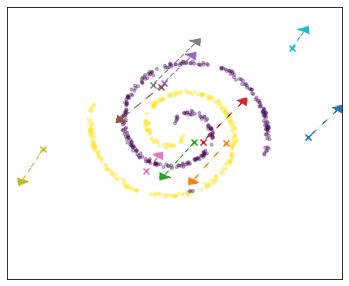

In [451]:
yout = net(xx)
ax = plt.figure(figsize=(6,5)).add_subplot()
out = (yout.data.cpu().numpy()>0.5).astype(int)
ax.scatter(x1, x2, c=out, marker= '.', alpha=0.3)
## plot centroids
c = net.net[0].centers.data.cpu()
d = net.net[-1].weight.data.cpu().t()*0.2 #+ net.net[-1].bias.data.cpu()


for i in range(c.shape[0]):
    color = matplotlib.cm.tab10(i)
    ax.arrow(c[i,0], c[i,1], d[i,0], d[i,1], head_width=0.15, head_length=0.1, fc=color, ec=color, linestyle=(0, (5, 10)))
    ax.scatter(c[i,0], c[i,1], color=color, marker= 'x')
    
plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
plt.xlim(-1.9, 1.8)
plt.ylim(-2.2, 1.8)

# plt.savefig("./outputs/01.0_viz_clf_vector_0.pdf", bbox_inches='tight')
plt.show()